In [1]:
# Cella 1: Setup del Progetto e Librerie

# -------------------------------------------
# Gestione File e Sistema Operativo
# -------------------------------------------
import os
import zipfile

# -------------------------------------------
# Manipolazione Dati e Calcolo Numerico
# -------------------------------------------
import numpy as np
import pandas as pd

# -------------------------------------------
# Audio Processing
# -------------------------------------------
import librosa
import librosa.display

# -------------------------------------------
# Visualizzazione
# -------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------------------
# Machine Learning e Deep Learning
# -------------------------------------------
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    PReLU,
    MaxPooling2D,
    Conv2DTranspose,
    Add,
    Flatten,
    Dense,
    Dropout,
    BatchNormalization
)
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm

# Impostiamo uno stile per i grafici e verifichiamo la GPU
plt.style.use('seaborn-v0_8-darkgrid')
print("TensorFlow Version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
if len(tf.config.experimental.list_physical_devices('GPU')) > 0:
    print("GPU sarà usata per l'addestramento.")
else:
    print("ATTENZIONE: Nessuna GPU trovata. L'addestramento sarà estremamente lento.")

TensorFlow Version: 2.18.0
Num GPUs Available:  1
GPU sarà usata per l'addestramento.


In [2]:
# Cella 2: Download e Estrazione del Dataset GTZAN

# -------------------------------------------
# Configurazione dell'API di Kaggle
# -------------------------------------------
!pip install -q kaggle
!mkdir -p ~/.kaggle

from google.colab import files
print("Per favore, carica il tuo file 'kaggle.json'...")
uploaded = files.upload()

!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
print("\nConfigurazione Kaggle completata.")

# -------------------------------------------
# Download ed Estrazione del Dataset
# -------------------------------------------
DATASET_PATH = "dataset"
DATASET_ZIP_PATH = "gtzan-dataset-music-genre-classification.zip"

if not os.path.exists(DATASET_PATH):
    print("\nDownload del dataset GTZAN in corso...")
    !kaggle datasets download -d andradaolteanu/gtzan-dataset-music-genre-classification
    print("\nEstrazione del dataset in corso...")
    with zipfile.ZipFile(DATASET_ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(DATASET_PATH)
    os.remove(DATASET_ZIP_PATH)
    print("Download ed Estrazione completati.")
else:
    print(f"\nLa directory '{DATASET_PATH}' esiste già.")

# -------------------------------------------
# Verifica del contenuto e pulizia
# -------------------------------------------
GENRES_PATH = os.path.join(DATASET_PATH, 'Data', 'genres_original')
corrupted_file_path = os.path.join(GENRES_PATH, 'jazz', 'jazz.00054.wav')
if os.path.exists(corrupted_file_path):
    os.remove(corrupted_file_path)
    print(f"Rimosso file corrotto: {corrupted_file_path}")

print(f"\nGeneri musicali trovati in '{GENRES_PATH}':")
genres = sorted([d for d in os.listdir(GENRES_PATH) if os.path.isdir(os.path.join(GENRES_PATH, d))])
print(genres)

Per favore, carica il tuo file 'kaggle.json'...


Saving kaggle.json to kaggle (1).json

Configurazione Kaggle completata.

La directory 'dataset' esiste già.

Generi musicali trovati in 'dataset/Data/genres_original':
['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


In [3]:
# Cella 3 (Versione Finale): Preprocessing con Chunking (Frammentazione)

# -------------------------------------------
# Costanti di Preprocessing
# -------------------------------------------
NPZ_PATH_CHUNKS = "spectrograms_128_chunks.npz"
IMG_SIZE_CHUNKS = 128
SAMPLE_RATE = 22050
DURATION_FULL = 30 # Durata totale del file
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION_FULL

NUM_CHUNKS = 10
SAMPLES_PER_CHUNK = int(SAMPLES_PER_TRACK / NUM_CHUNKS)

N_MELS = 128
HOP_LENGTH = 512
N_FFT = 2048

# -------------------------------------------
# Funzione di Preprocessing con Chunking
# -------------------------------------------
def create_chunked_spectrograms(data_path, npz_path, img_size, num_chunks, samples_per_chunk):
    if os.path.exists(npz_path):
        print(f"File '{npz_path}' trovato. Salto il preprocessing.")
        return

    data = {"images": [], "labels": []}
    all_genres = sorted([d for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))])

    print(f"Inizio preprocessing con chunking ({num_chunks} chunk per brano)...")
    for genre_idx, genre_label in enumerate(tqdm(all_genres, desc="Generi")):
        genre_path = os.path.join(data_path, genre_label)
        for filename in os.listdir(genre_path):
            if filename.endswith('.wav'):
                file_path = os.path.join(genre_path, filename)
                try:
                    signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)

                    # Suddividiamo il segnale in chunk
                    for c in range(num_chunks):
                        start_sample = samples_per_chunk * c
                        end_sample = start_sample + samples_per_chunk

                        if end_sample <= len(signal):
                            chunk_signal = signal[start_sample:end_sample]

                            mel_spec = librosa.feature.melspectrogram(y=chunk_signal, sr=sr, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS)
                            log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

                            img = (log_mel_spec - log_mel_spec.min()) / (log_mel_spec.max() - log_mel_spec.min())
                            img = (img * 255).astype(np.uint8)

                            img_gray = img[..., np.newaxis]
                            resized_spec = tf.image.resize(img_gray, [img_size, img_size], method='bilinear')
                            img_rgb = tf.image.grayscale_to_rgb(resized_spec)

                            data["images"].append(img_rgb.numpy().astype(np.uint8))
                            data["labels"].append(genre_idx)
                except Exception as e:
                    print(f"\nErrore durante l'elaborazione di {file_path}: {e}")

    np.savez_compressed(npz_path, X=np.array(data["images"]), y=np.array(data["labels"]), mappings=all_genres)
    print(f"\nDati salvati in '{npz_path}'. Shape totale: {np.array(data['images']).shape}")

# Eseguiamo la funzione
create_chunked_spectrograms(GENRES_PATH, NPZ_PATH_CHUNKS, IMG_SIZE_CHUNKS, NUM_CHUNKS, SAMPLES_PER_CHUNK)

File 'spectrograms_128_chunks.npz' trovato. Salto il preprocessing.


In [7]:
# Cella 4 (Finale - Corretta v2)

import gc
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, PReLU, MaxPooling2D, Conv2DTranspose,
    Add, Dense, Dropout, GlobalAveragePooling2D
)

# -------------------------------------------
# 1. Caricamento dei Dati Chunked
# -------------------------------------------
NPZ_PATH_CHUNKS = "spectrograms_128_chunks.npz"

print(f"Caricamento dati chunked da '{NPZ_PATH_CHUNKS}'...")
with np.load(NPZ_PATH_CHUNKS, allow_pickle=True) as data:
    X_full = data['X']
    y_full = data['y']
    mappings = data['mappings']

print(f"Dati caricati. Shape totale di X: {X_full.shape}, Shape di y: {y_full.shape}")

# -------------------------------------------
# 2. Preparazione dei Dati
# -------------------------------------------
X_normalized = X_full.astype('float32') / 255.
y_one_hot = to_categorical(y_full)
X_train, X_test, y_train, y_test = train_test_split(
    X_normalized, y_one_hot, test_size=0.2, random_state=42, stratify=y_one_hot
)

print("\nDati suddivisi e pronti per l'addestramento.")
print(f"Shape X_train: {X_train.shape}")
print(f"Shape X_test: {X_test.shape}")

del X_full, y_full, X_normalized, y_one_hot
gc.collect()

# -------------------------------------------
# 3. Costruzione del Modello Ibrido (Adattato a 128x128)
# -------------------------------------------
def build_hybrid_unet_cnn_128(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Corpo U-Net
    # Encoder
    conv1 = Conv2D(32, (3, 3), padding='same')(inputs)
    prelu1 = PReLU(shared_axes=[1, 2])(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(prelu1)

    conv2 = Conv2D(64, (3, 3), padding='same')(pool1)
    prelu2 = PReLU(shared_axes=[1, 2])(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(prelu2)

    # Bottleneck
    conv3 = Conv2D(128, (3, 3), padding='same')(pool2)
    prelu3 = PReLU(shared_axes=[1, 2])(conv3)

    # Decoder
    up2 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(prelu3)
    skip2 = Add()([up2, prelu2])
    conv2_dec = Conv2D(64, (3, 3), padding='same')(skip2)
    prelu2_dec = PReLU(shared_axes=[1, 2])(conv2_dec)

    up1 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(prelu2_dec)
    skip1 = Add()([up1, prelu1])
    conv1_dec = Conv2D(32, (3, 3), padding='same')(skip1)
    unet_output = PReLU(shared_axes=[1, 2])(conv1_dec)

    # Testa di Classificazione CNN
    head_conv1 = Conv2D(64, (3, 3), padding='same', activation='relu')(unet_output)
    head_pool1 = MaxPooling2D(pool_size=(2, 2))(head_conv1)

    head_conv2 = Conv2D(128, (3, 3), padding='same', activation='relu')(head_pool1)
    head_pool2 = MaxPooling2D(pool_size=(2, 2))(head_conv2)

    gap = GlobalAveragePooling2D()(head_pool2)
    dropout = Dropout(0.5)(gap)
    outputs = Dense(num_classes, activation='softmax')(dropout)

    hybrid_model = Model(inputs=inputs, outputs=outputs)
    return hybrid_model

# Definiamo le costanti per il nuovo modello
IMG_SIZE_CHUNKS = 128
INPUT_SHAPE_128 = (IMG_SIZE_CHUNKS, IMG_SIZE_CHUNKS, 3)
NUM_CLASSES = len(mappings)

# Costruiamo e compiliamo
model = build_hybrid_unet_cnn_128(INPUT_SHAPE_128, NUM_CLASSES)
optimizer = keras.optimizers.Adam(learning_rate=0.001) # Proviamo un LR più aggressivo con più dati
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Caricamento dati chunked da 'spectrograms_128_chunks.npz'...
Dati caricati. Shape totale di X: (9981, 128, 128, 3), Shape di y: (9981,)

Dati suddivisi e pronti per l'addestramento.
Shape X_train: (7984, 128, 128, 3)
Shape X_test: (1997, 128, 128, 3)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 128, 128,  │        896 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu_5 (PReLU)   │ (None, 128, 128,  │         32 │ conv2d_7[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 64, 64,    │          0 │ p_re_lu_5[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu_6 (PReLU)   │ (None, 64, 64,    │         64 │ conv2d_8[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 32, 32,    │          0 │ p_re_lu_6[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_5[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu_7 (PReLU)   │ (None, 32, 32,    │        128 │ conv2d_9[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_2  │ (None, 64, 64,    │     32,832 │ p_re_lu_7[0][0]   │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 64, 64,    │          0 │ conv2d_transpose… │
│                     │ 64)               │            │ p_re_lu_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 64, 64,    │     36,928 │ add_2[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu_8 (PReLU)   │ (None, 64, 64,    │         64 │ conv2d_10[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_3  │ (None, 128, 128,  │      8,224 │ p_re_lu_8[0][0]   │
│ (Conv2DTranspose)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 128, 128,  │          0 │ conv2d_transpose… │
│                     │ 32)               │            │ p_re_lu_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 128, 128,  │      9,248 │ add_3[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu_9 (PReLU)   │ (None, 128, 128,  │         32 │ conv2d_11[0][0] 

 Total params: 274,442 (1.05 MB)

 Trainable params: 274,442 (1.05 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Cella 5 (Finale): Addestramento sul Dataset Chunked

# -------------------------------------------
# Definizione dei Parametri di Addestramento
# -------------------------------------------
EPOCHS = 50 # 50 epoche sono un buon punto di partenza con così tanti dati.
BATCH_SIZE = 32 # Possiamo usare un batch size più grande ora che le immagini sono più piccole
MODEL_CHECKPOINT_PATH = "best_chunked_model.keras"

# -------------------------------------------
# Definizione dei Callbacks
# -------------------------------------------

# 1. ModelCheckpoint
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=MODEL_CHECKPOINT_PATH,
    monitor='val_accuracy', # Monitoriamo l'accuracy, ora dovrebbe essere più stabile
    verbose=1,
    save_best_only=True,
    mode='max'
)

# 2. EarlyStopping
early_stopping_callback = keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=10, # 10 epoche di pazienza
    verbose=1,
    restore_best_weights=True
)

# 3. ReduceLROnPlateau
reduce_lr_callback = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', # Questo callback lavora meglio sulla loss
    factor=0.2,
    patience=4,
    verbose=1,
    min_lr=1e-6
)

# -------------------------------------------
# Avvio dell'Addestramento
# -------------------------------------------
print("--- Avvio Addestramento Finale (Dati Chunked) ---")

history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]
)

print("\n--- Addestramento Finale Completato ---")


# -------------------------------------------
# Salva la cronologia per l'analisi
# -------------------------------------------
history_df = pd.DataFrame(history.history)
history_df.to_csv('training_history.csv', index=False)
print("\nCronologia dell'addestramento salvata in 'training_history.csv'")

--- Avvio Addestramento Finale (Dati Chunked) ---
Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.1426 - loss: 2.2417
Epoch 1: val_accuracy improved from -inf to 0.35153, saving model to best_chunked_model.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 53s 153ms/step - accuracy: 0.1428 - loss: 2.2413 - val_accuracy: 0.3515 - val_loss: 1.7232 - learning_rate: 0.0010
Epoch 2/50
249/250 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.3222 - loss: 1.8295
Epoch 2: val_accuracy improved from 0.35153 to 0.40911, saving model to best_chunked_model.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 85ms/step - accuracy: 0.3223 - loss: 1.8291 - val_accuracy: 0.4091 - val_loss: 1.5953 - learning_rate: 0.0010
Epoch 3/50
249/250 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.3673 - loss: 1.6798
Epoch 3: val_accuracy improved from 0.40911 to 0.46770, saving model to best_chunked_model.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 85ms/step - accuracy: 0.3675 - loss: 1.6793 - val_accuracy: 0.4677 - val_loss: 1

Caricamento del miglior modello da 'best_chunked_model.keras'...
Modello caricato.


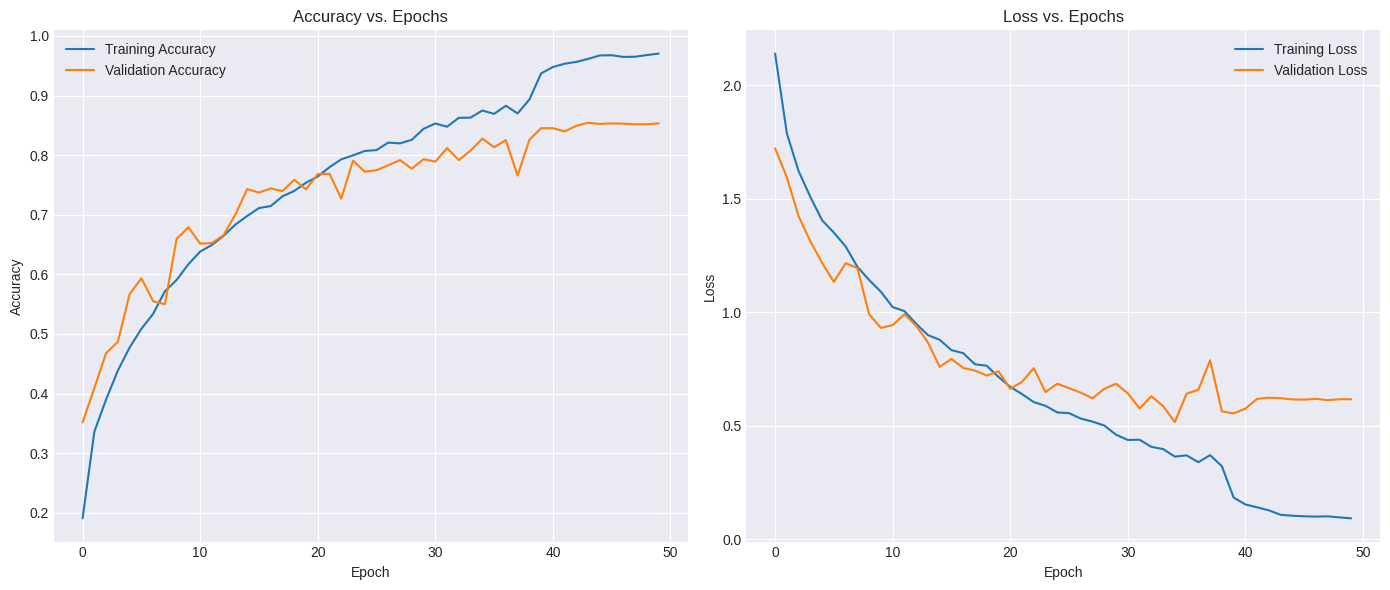


--- Valutazione Finale sul Test Set ---
Accuratezza sul Test Set: 85.43%
Loss sul Test Set: 0.6219
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step


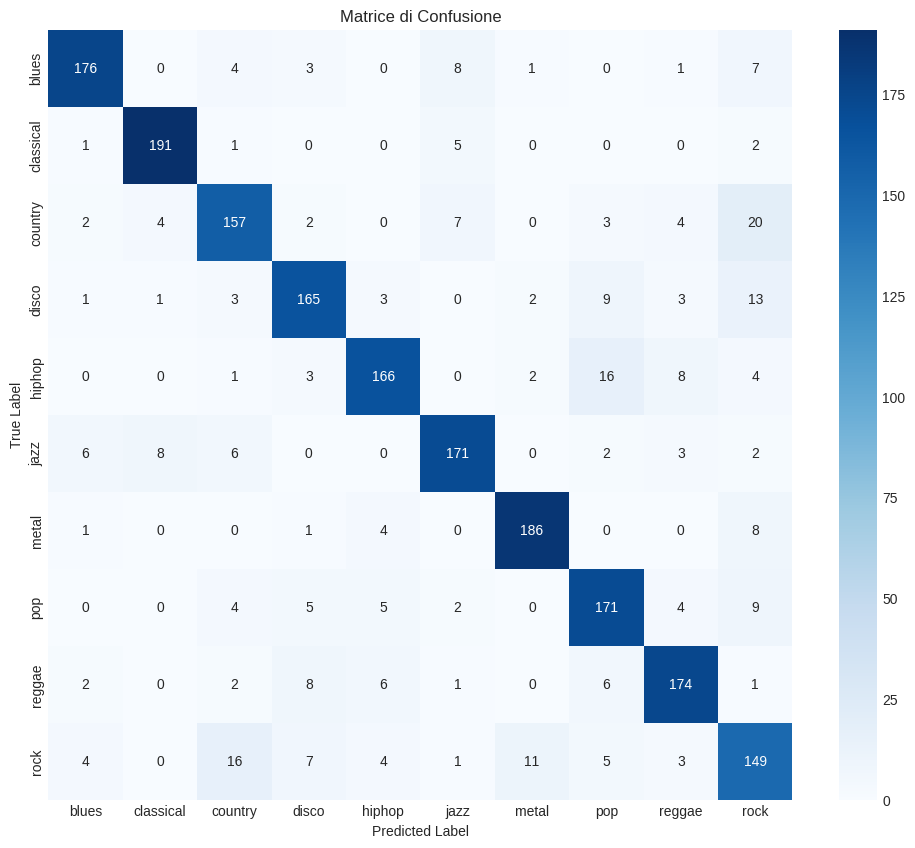


--- Classification Report ---
              precision    recall  f1-score   support

       blues       0.91      0.88      0.90       200
   classical       0.94      0.95      0.95       200
     country       0.81      0.79      0.80       199
       disco       0.85      0.82      0.84       200
      hiphop       0.88      0.83      0.86       200
        jazz       0.88      0.86      0.87       198
       metal       0.92      0.93      0.93       200
         pop       0.81      0.85      0.83       200
      reggae       0.87      0.87      0.87       200
        rock       0.69      0.74      0.72       200

    accuracy                           0.85      1997
   macro avg       0.86      0.85      0.85      1997
weighted avg       0.86      0.85      0.85      1997



In [9]:
# Cella 6: Analisi dei Risultati e Valutazione del Modello

# -------------------------------------------
# 1. Caricamento del Miglior Modello Salvato
# -------------------------------------------
print(f"Caricamento del miglior modello da '{MODEL_CHECKPOINT_PATH}'...")
best_model = keras.models.load_model(MODEL_CHECKPOINT_PATH)
print("Modello caricato.")

# -------------------------------------------
# 2. Visualizzazione delle Curve di Apprendimento
# -------------------------------------------
history_df = pd.read_csv('training_history.csv')

plt.figure(figsize=(14, 6))

# Grafico dell'Accuratezza
plt.subplot(1, 2, 1)
plt.plot(history_df['accuracy'], label='Training Accuracy')
plt.plot(history_df['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Grafico della Loss
plt.subplot(1, 2, 2)
plt.plot(history_df['loss'], label='Training Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# -------------------------------------------
# 3. Valutazione Finale sul Test Set
# -------------------------------------------
print("\n--- Valutazione Finale sul Test Set ---")
loss, accuracy = best_model.evaluate(X_test, y_test, verbose=0)
print(f"Accuratezza sul Test Set: {accuracy * 100:.2f}%")
print(f"Loss sul Test Set: {loss:.4f}")

# -------------------------------------------
# 4. Matrice di Confusione e Classification Report
# -------------------------------------------
# Otteniamo le predizioni dal modello
y_pred_probs = best_model.predict(X_test)
y_pred_labels = np.argmax(y_pred_probs, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Matrice di Confusione
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=mappings, yticklabels=mappings)
plt.title('Matrice di Confusione')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Classification Report
print("\n--- Classification Report ---")
print(classification_report(y_true_labels, y_pred_labels, target_names=mappings))